# Evaluation of RNATracker

Paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6612824/

Keras model reference: https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py

Some notes:
* It appears that early stopping is disabled in their code, and instead the model trains for 100 epochs without additional consideration
* The original paper uses Nesterov Adam, we use vanilla Adam since Nesterov Adam isn't readily available under pytorch - we do not expect this to make a meaningful difference
* Paper does not make use of LR scheduling, so we will omit that as well.

In [1]:
import os
import sys
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import skorch
import skorch.helper

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

# Figure out local paths
SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import utils
import seq

MODEL_DIR = os.path.join(SRC_DIR, 'models')
assert os.path.isdir(MODEL_DIR)
sys.path.append(MODEL_DIR)
import rnatracker

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

np.random.seed(27492)
SEED = 27492

print('The scikit-learn version is {}.'.format(sklearn.__version__))

DEVICE = utils.get_device(0)

INFO:root:GeForce GTX 1080 Ti


The scikit-learn version is 0.21.3.


In [2]:
importlib.reload(data_loader)
K_FOLD = 5
train_dataset = data_loader.LocalizationClassificationOneHotQuarters("train", k_fold=K_FOLD)
valid_dataset = data_loader.LocalizationClassificationOneHotQuarters("valid", k_fold=K_FOLD)
test_dataset = data_loader.LocalizationClassificationOneHotQuarters("test", k_fold=K_FOLD)
# full_dataset = data_loader.LocalizationClassificationOneHotQuarters("all", k_fold=K_FOLD)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [3]:
train_dataset[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]),
 tensor([1., 0., 0., 0., 0., 0., 1., 0.]))

In [4]:
train_data = data_loader.load_data_as_np(train_dataset, check_dims=False)
valid_data = data_loader.load_data_as_np(valid_dataset, check_dims=False)
test_data = data_loader.load_data_as_np(test_dataset, check_dims=False)

100%|██████████| 366/366 [00:02<00:00, 130.84it/s]


In [5]:
importlib.reload(rnatracker)

rt = skorch.NeuralNet(
    module=rnatracker.RNATracker,
#     module__final_act=lambda x: F.softmax(x, dim=-1),
    lr=1e-3,  # Paper does not mention
    criterion=nn.BCELoss,  # Modified from paper which uses KL loss
    optimizer=torch.optim.Adam,  # From paper
    iterator_train__shuffle=True,
    device=DEVICE,
    batch_size=256,  # From paper
    max_epochs=100,  # From paper
#     callbacks=[
#         skorch.callbacks.EarlyStopping(patience=7),  # Paper's source code comments out a early stopping of 7
#     ],
    train_split=skorch.helper.predefined_split(valid_dataset),
    iterator_train__num_workers=6,
    iterator_valid__num_workers=6,
)

rt.fit(train_dataset, y=None)

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6230        0.5324  8.4642
      2        0.4795        0.4502  8.4605
      3        0.4470        0.4377  8.4005
      4        0.4410        0.4350  8.4159
      5        0.4395        0.4335  8.4908
      6        0.4384        0.4321  8.4164
      7        0.4374        0.4311  8.4074
      8        0.4366        0.4305  8.4281
      9        0.4359        0.4295  8.4655
     10        0.4356        0.4285  8.4723
     11        0.4348        0.4269  8.4757
     12        0.4340        0.4262  8.4710
     13        0.4333        0.4252  8.4775
     14        0.4332        0.4252  8.4263
     15        0.4326        0.4243  8.5198
     16        0.4325        0.4246  8.4514
     17        0.4317        0.4256  8.4507
     18        0.4336        0.4261  8.4671
     19        0.4326        0.4256  8.4468
     20        0.4321        0.4243  8.4443
     21        0.4316        0.4

<class 'skorch.net.NeuralNet'>[initialized](
  module_=RNATracker(
    (cnn1): Conv1d(4, 32, kernel_size=(10,), stride=(1,), bias=False)
    (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.2, inplace=False)
    (cnn2): Conv1d(32, 32, kernel_size=(10,), stride=(1,), bias=False)
    (maxpool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (lstm): LSTM(32, 32, dropout=0.1, bidirectional=True)
    (attention): Attention(
      (context): Linear(in_features=64, out_features=50, bias=True)
      (attn): Linear(in_features=50, out_features=1, bias=True)
    )
    (fc): Linear(in_features=64, out_features=8, bias=True)
  ),
)

In [6]:
rt_test_preds = rt.predict_proba(test_dataset)
rt_test_preds

array([[0.11462077, 0.15151195, 0.10858969, ..., 0.4679709 , 0.10730878,
        0.15083958],
       [0.6328266 , 0.2672876 , 0.03326568, ..., 0.13931687, 0.01247308,
        0.22845605],
       [0.46098173, 0.18322554, 0.07195061, ..., 0.20296943, 0.03985145,
        0.36180595],
       ...,
       [0.6235809 , 0.26715183, 0.03380751, ..., 0.13808373, 0.01268323,
        0.22675693],
       [0.636345  , 0.2622376 , 0.03536673, ..., 0.14651929, 0.01495858,
        0.27685735],
       [0.49993515, 0.19046216, 0.06946041, ..., 0.20002091, 0.04044499,
        0.41218194]], dtype=float32)

In [7]:
rt_test_per_class_perf = model_utils.generate_multiclass_perf(test_data[1], rt_test_preds, 8)
rt_test_overall_perf = model_utils.generate_model_perf(test_data[1], rt_test_preds, multiclass=True)

0.698428199477971
0.33527068009282324


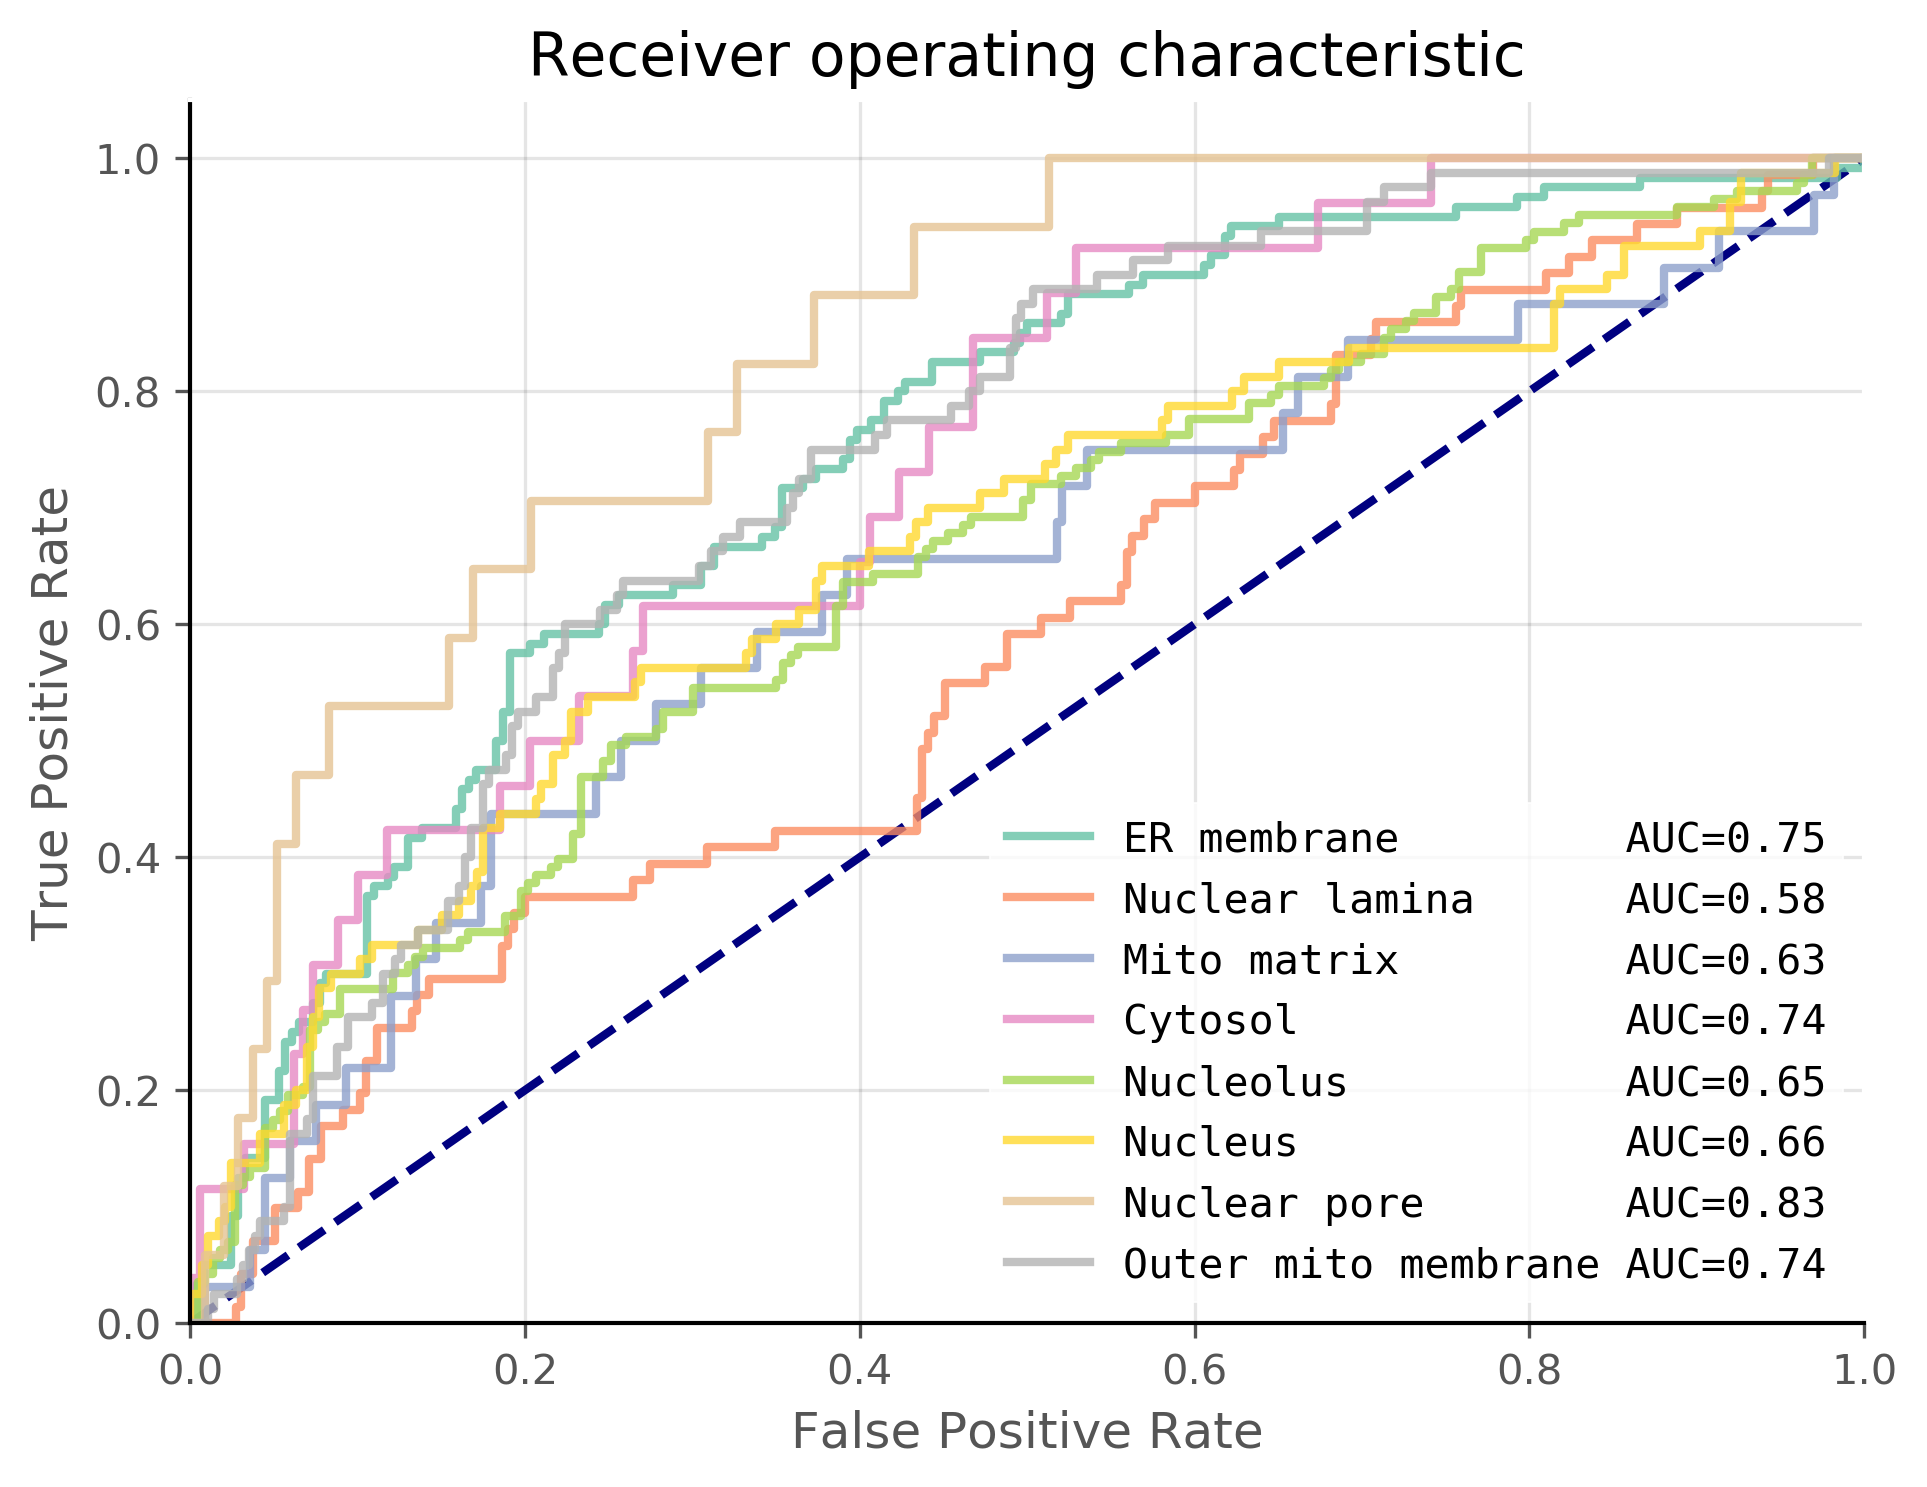

In [8]:
print(rt_test_overall_perf.auroc)
print(rt_test_overall_perf.auprc)

importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(test_dataset.compartments, rt_test_per_class_perf)},
    bg_color='white',
)

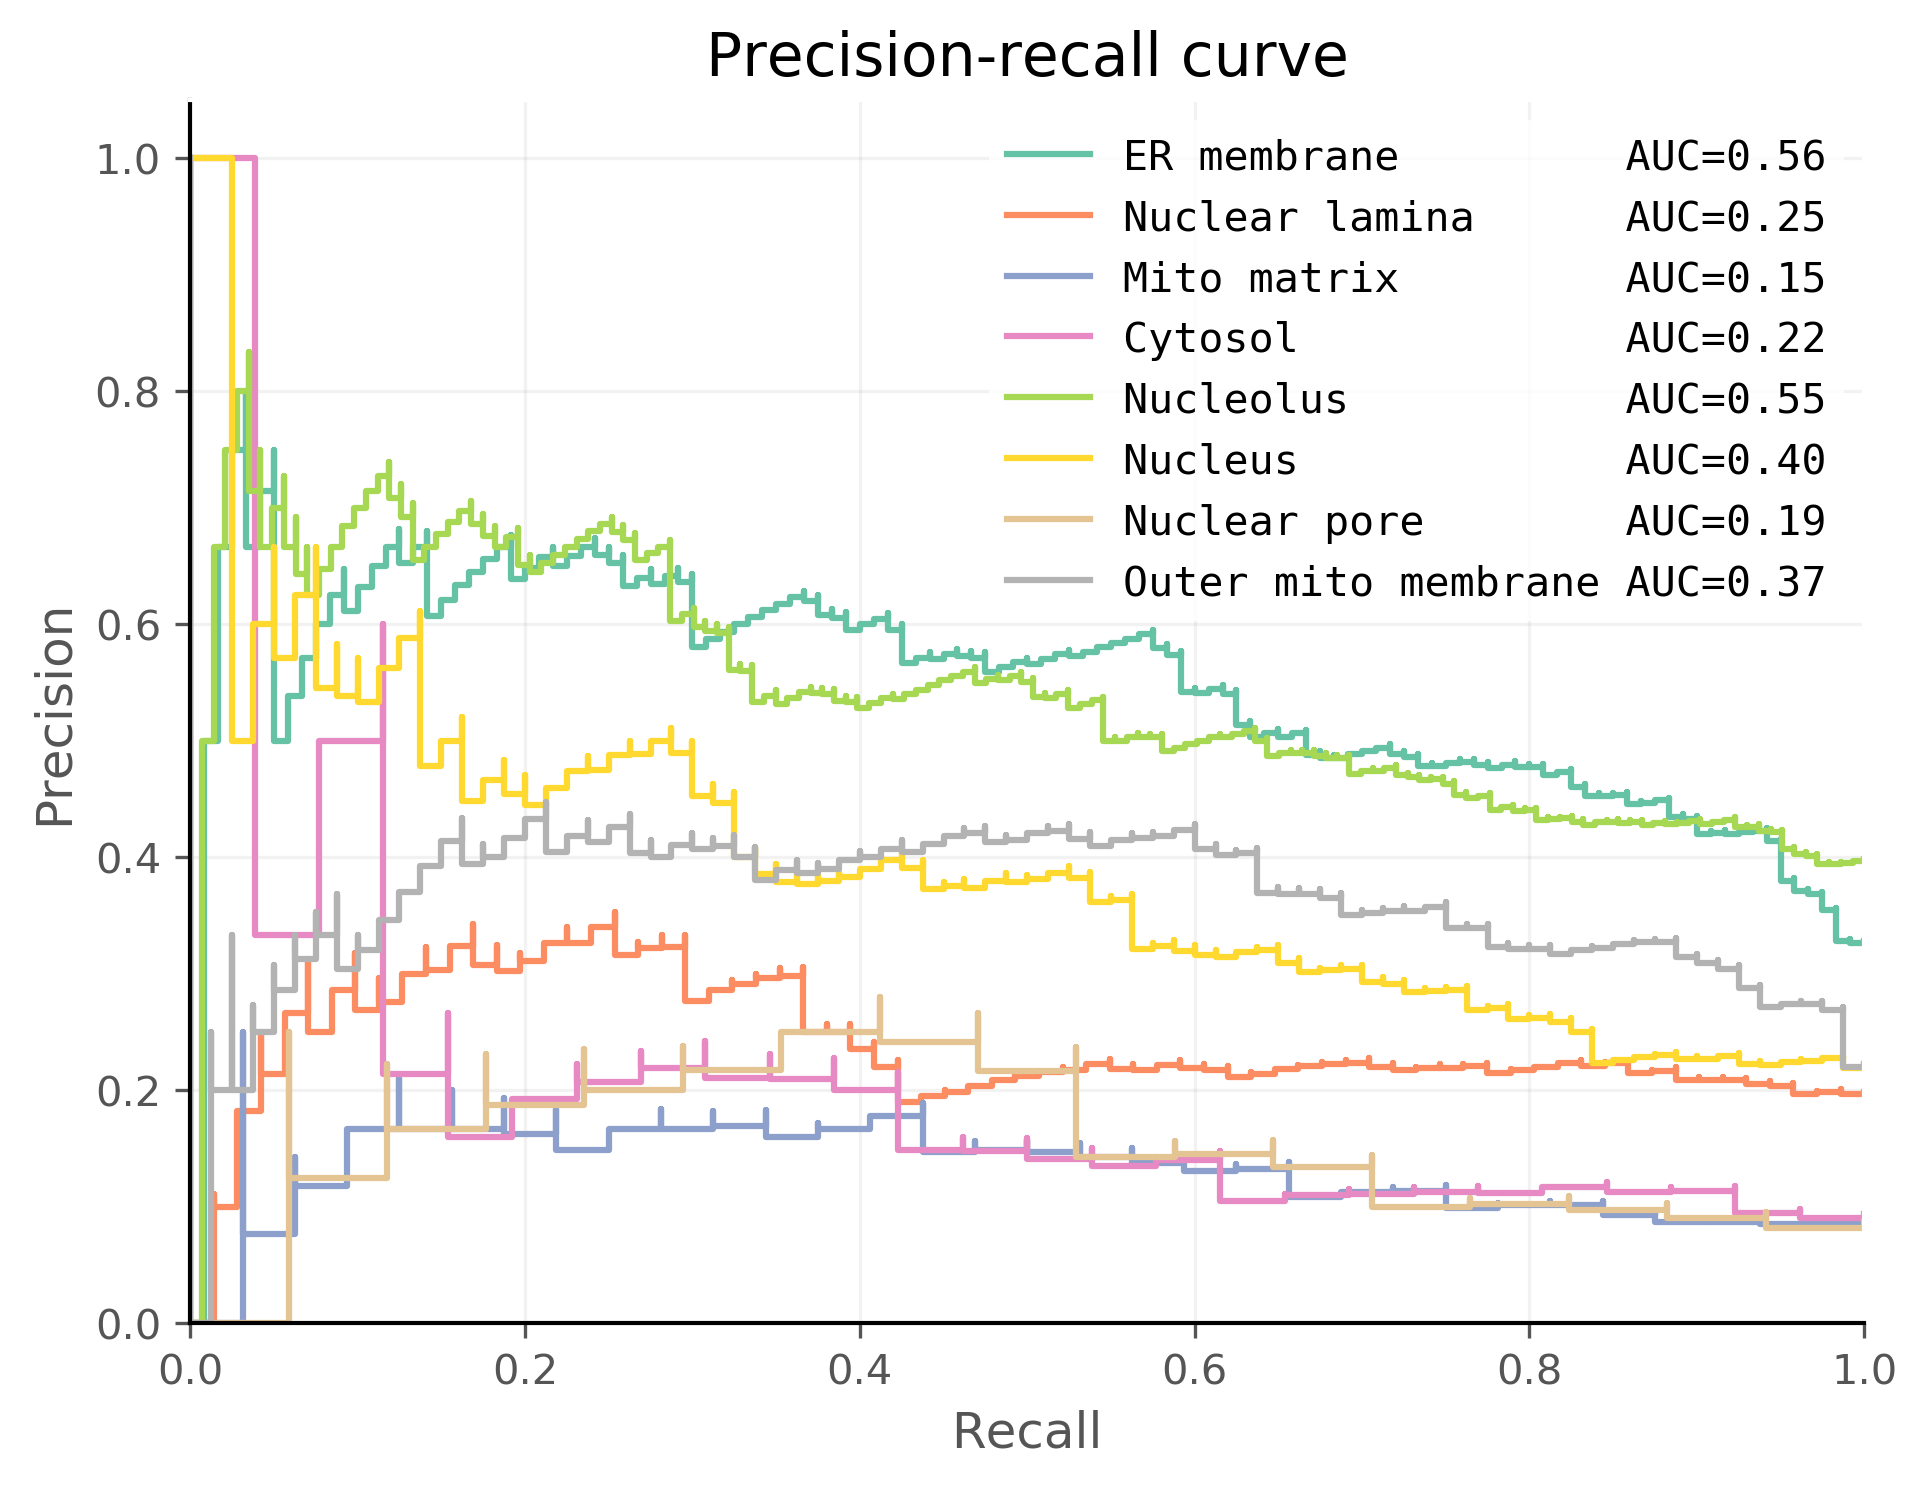

In [9]:
importlib.reload(plotting_utils)
plotting_utils.plot_auprc(
    {data_loader.LOCALIZATION_FULL_NAME_DICT[l]: perf for l, perf in zip(test_dataset.compartments, rt_test_per_class_perf)},
    grid=True,
    bg_color='white',
)

# Cross-validation
Run each through cross-validation and record results

In [11]:
cv_train_datasets = []
cv_valid_datasets = []
cv_test_datasets = []
for i in range(10):
    train_dset = data_loader.LocalizationClassificationOneHotQuarters("train", k_fold=i)
    valid_dset = data_loader.LocalizationClassificationOneHotQuarters("valid", k_fold=i)
    test_dset = data_loader.LocalizationClassificationOneHotQuarters("test", k_fold=i)
    cv_train_datasets.append(train_dset)
    cv_valid_datasets.append(valid_dset)
    cv_test_datasets.append(test_dset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 983/2928 = 0.335724043715847 positive
INFO:root:Lma - 617/2928 = 0.210724043715847 positive
INFO:root:Mito - 229/2928 = 0.0782103825136612 positive
INFO:root:Nes - 167/2928 = 0.05703551912568306 positive
INFO:root:Nik - 1107/2928 = 0.3780737704918033 positive
INFO:root:Nls - 655/2928 = 0.22370218579234974 positive
INFO:root:NucPore - 132/2928 = 0.045081967213114756 positive
INFO:root:Omm - 585/2928 = 0.19979508196721313 positive
INFO:root:2605	0.8896857923497268	protein_coding
INFO:root:81	0.027663934426229508	antisense_RNA
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:37	0.012636612021857924	transcribed_unprocessed_pseudogene
INFO:root:35	0.011953551912568305	processed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript
INFO

INFO:root:322	0.8797814207650273	protein_coding
INFO:root:13	0.03551912568306011	antisense_RNA
INFO:root:6	0.01639344262295082	lincRNA
INFO:root:6	0.01639344262295082	processed_pseudogene
INFO:root:5	0.01366120218579235	transcribed_unprocessed_pseudogene
INFO:root:4	0.01092896174863388	Mt_tRNA
INFO:root:3	0.00819672131147541	processed_transcript
INFO:root:2	0.00546448087431694	transcribed_processed_pseudogene
INFO:root:2	0.00546448087431694	unprocessed_pseudogene
INFO:root:1	0.00273224043715847	transcribed_unitary_pseudogene
INFO:root:1	0.00273224043715847	sense_overlapping
INFO:root:1	0.00273224043715847	misc_RNA
INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 952/2928 = 0.3251366120218579 positive
INFO:root:Lma - 613/2928 = 0.20935792349726776 positive
INFO:root:Mito - 235/2928 = 0.0802595

INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 129/366 = 0.3524590163934426 positive
INFO:root:Lma - 77/366 = 0.2103825136612022 positive
INFO:root:Mito - 16/366 = 0.04371584699453552 positive
INFO:root:Nes - 22/366 = 0.060109289617486336 positive
INFO:root:Nik - 146/366 = 0.3989071038251366 positive
INFO:root:Nls - 88/366 = 0.24043715846994534 positive
INFO:root:NucPore - 19/366 = 0.05191256830601093 positive
INFO:root:Omm - 58/366 = 0.15846994535519127 positive
INFO:root:328	0.8961748633879781	protein_coding
INFO:root:11	0.030054644808743168	lincRNA
INFO:root:5	0.01366120218579235	transcribed_unprocessed_pseudogene
INFO:root:4	0.01092896174863388	processed_transcript
INFO:root:4	0.01092896174863388	antisense_RNA
INFO:root:4	0.01092896174863388	processed_pseudogene
INFO:root:2	0.00546448087431694	unprocessed_pseudogene
INFO:root:2	0.00546448087431694	rRNA
INFO:root:2	0.00546448087431694	sense_intronic
INFO:root:1	0.00273224043715847	translated_processed_pseudogene

INFO:root:2	0.00546448087431694	processed_pseudogene
INFO:root:1	0.00273224043715847	Mt_tRNA
INFO:root:1	0.00273224043715847	miRNA
INFO:root:1	0.00273224043715847	misc_RNA
INFO:root:1	0.00273224043715847	transcribed_processed_pseudogene
INFO:root:1	0.00273224043715847	unprocessed_pseudogene
INFO:root:1	0.00273224043715847	3prime_overlapping_ncRNA
INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 120/366 = 0.32786885245901637 positive
INFO:root:Lma - 71/366 = 0.19398907103825136 positive
INFO:root:Mito - 32/366 = 0.08743169398907104 positive
INFO:root:Nes - 26/366 = 0.07103825136612021 positive
INFO:root:Nik - 143/366 = 0.3907103825136612 positive
INFO:root:Nls - 80/366 = 0.2185792349726776 positive
INFO:root:NucPore - 17/366 = 0.04644808743169399 positive
INFO:root:Omm - 80/366 = 0.21857923497

INFO:root:Nls - 76/366 = 0.20765027322404372 positive
INFO:root:NucPore - 17/366 = 0.04644808743169399 positive
INFO:root:Omm - 68/366 = 0.18579234972677597 positive
INFO:root:325	0.8879781420765027	protein_coding
INFO:root:15	0.040983606557377046	antisense_RNA
INFO:root:5	0.01366120218579235	processed_pseudogene
INFO:root:4	0.01092896174863388	lincRNA
INFO:root:4	0.01092896174863388	processed_transcript
INFO:root:2	0.00546448087431694	transcribed_processed_pseudogene
INFO:root:2	0.00546448087431694	transcribed_unprocessed_pseudogene
INFO:root:2	0.00546448087431694	Mt_tRNA
INFO:root:2	0.00546448087431694	sense_overlapping
INFO:root:2	0.00546448087431694	misc_RNA
INFO:root:1	0.00273224043715847	pseudogene
INFO:root:1	0.00273224043715847	unprocessed_pseudogene
INFO:root:1	0.00273224043715847	sense_intronic
INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:r

INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 127/366 = 0.3469945355191257 positive
INFO:root:Lma - 81/366 = 0.22131147540983606 positive
INFO:root:Mito - 24/366 = 0.06557377049180328 positive
INFO:root:Nes - 20/366 = 0.0546448087431694 positive
INFO:root:Nik - 134/366 = 0.366120218579235 positive
INFO:root:Nls - 83/366 = 0.226775956284153 positive
INFO:root:NucPore - 19/366 = 0.05191256830601093 positive
INFO:root:Omm - 74/366 = 0.20218579234972678 positive
INFO:root:324	0.8852459016393442	protein_coding
INFO:root:12	0.03278688524590164	lincRNA
INFO:root:9	0.02459016393442623	antisense_RNA
INFO:root:6	0.01639344262295082	transcribed_unprocessed_pseudogene
INFO:root:6	0.01639344262295082	processed_pseudogene
INFO:root:5	0.01366120218579235	processed_transcript
INFO:root:2	0.00546448087431694	sense_overlapping
INFO:root:1	0.00273224043715847	unprocessed_pseudogene
INFO:root:1	0.00273224043715847	rRNA
INFO:root:Read deseq table containing results for localizations: 

In [12]:
cv_aurocs = []
cv_auprcs = []
cv_models = []
for train_dset, valid_dset, test_dset in tqdm.tqdm_notebook(zip(cv_train_datasets, cv_valid_datasets, cv_test_datasets)):
    rt = skorch.NeuralNet(
        module=rnatracker.RNATracker,
    #     module__final_act=lambda x: F.softmax(x, dim=-1),
        lr=1e-3,  # Paper does not mention
        criterion=nn.BCELoss,  # Modified from paper which uses KL loss
        optimizer=torch.optim.Adam,  # From paper
        iterator_train__shuffle=True,
        device=DEVICE,
        batch_size=256,  # From paper
        max_epochs=100,  # From paper
    #     callbacks=[
    #         skorch.callbacks.EarlyStopping(patience=7),  # Paper's source code comments out a early stopping of 7
    #     ],
        train_split=skorch.helper.predefined_split(valid_dset),
        iterator_train__num_workers=6,
        iterator_valid__num_workers=6,
    )
    rt.fit(train_dset, y=None)
    
    rt_test_preds = rt.predict_proba(test_dset)
    rt_test_per_class_perf = model_utils.generate_multiclass_perf(test_data[1], rt_test_preds, 8)
    rt_test_overall_perf = model_utils.generate_model_perf(test_data[1], rt_test_preds, multiclass=True)
    
    print(rt_test_overall_perf.auroc)
    print(rt_test_overall_perf.auprc)
    cv_aurocs.append(rt_test_overall_perf.auroc)
    cv_auprcs.append(rt_test_overall_perf.auprc)
    cv_models.append(rt)

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6230        0.5312  12.9836
      2        0.4797        0.4497  13.1793
      3        0.4467        0.4432  12.9647
      4        0.4410        0.4420  13.0288
      5        0.4392        0.4385  13.0267
      6        0.4383        0.4369  13.2494
      7        0.4374        0.4365  12.9718
      8        0.4367        0.4386  13.1960
      9        0.4361        0.4351  13.1827
     10        0.4356        0.4344  13.2046
     11        0.4349        0.4338  13.1534
     12        0.4342        0.4329  12.9888
     13        0.4332        0.4318  13.1447
     14        0.4327        0.4316  13.0605
     15        0.4322        0.4308  13.0082
     16        0.4317        0.4304  12.9223
     17        0.4312        0.4296  12.7548
     18        0.4308        0.4291  13.1226
     19        0.4306        0.4285  13.5354
     20        0.4303        0.4283  12.8840
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6227        0.5353  13.2818
      2        0.4789        0.4600  13.1796
      3        0.4456        0.4475  13.0906
      4        0.4399        0.4442  13.3155
      5        0.4380        0.4438  13.0321
      6        0.4368        0.4429  12.9166
      7        0.4360        0.4419  13.4136
      8        0.4356        0.4477  13.4139
      9        0.4352        0.4413  13.2602
     10        0.4342        0.4407  13.0092
     11        0.4336        0.4399  13.3013
     12        0.4328        0.4388  13.0921
     13        0.4319        0.4379  13.2363
     14        0.4311        0.4374  13.0161
     15        0.4307        0.4382  13.0514
     16        0.4301        0.4365  12.9281
     17        0.4295        0.4375  13.0066
     18        0.4294        0.4369  12.8074
     19        0.4290        0.4359  12.9676
     20        0.4286        0.4366  12.9166
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6229        0.5358  13.1037
      2        0.4796        0.4612  13.2436
      3        0.4457        0.4510  13.1563
      4        0.4400        0.4493  13.2672
      5        0.4382        0.4483  13.0195
      6        0.4371        0.4471  12.9705
      7        0.4363        0.4458  12.8453
      8        0.4356        0.4452  13.1731
      9        0.4350        0.4449  12.8077
     10        0.4346        0.4441  12.9934
     11        0.4340        0.4438  13.2656
     12        0.4337        0.4432  12.8886
     13        0.4327        0.4420  13.1479
     14        0.4319        0.4414  12.9518
     15        0.4313        0.4416  12.9395
     16        0.4307        0.4407  13.2480
     17        0.4302        0.4408  13.1819
     18        0.4305        0.4406  12.9227
     19        0.4294        0.4409  12.9723
     20        0.4295        0.4405  13.1433
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6230        0.5301  13.3897
      2        0.4813        0.4538  13.2416
      3        0.4480        0.4436  13.1531
      4        0.4421        0.4432  13.2903
      5        0.4404        0.4417  13.0013
      6        0.4392        0.4399  13.1658
      7        0.4385        0.4395  13.0146
      8        0.4379        0.4387  13.0203
      9        0.4372        0.4379  12.8648
     10        0.4369        0.4379  13.0050
     11        0.4361        0.4362  13.0289
     12        0.4352        0.4357  13.3362
     13        0.4345        0.4336  13.0565
     14        0.4337        0.4328  12.7880
     15        0.4332        0.4342  13.0463
     16        0.4328        0.4326  13.1814
     17        0.4320        0.4312  12.9804
     18        0.4319        0.4315  12.9226
     19        0.4317        0.4316  13.2682
     20        0.4313        0.4307  13.0641
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6229        0.5292  13.5128
      2        0.4815        0.4436  13.1380
      3        0.4485        0.4318  13.1367
      4        0.4429        0.4315  12.9113
      5        0.4414        0.4310  12.9384
      6        0.4403        0.4294  13.0027
      7        0.4394        0.4297  13.0518
      8        0.4387        0.4295  13.0532
      9        0.4380        0.4278  13.0479
     10        0.4377        0.4284  13.0442
     11        0.4372        0.4281  12.8701
     12        0.4364        0.4269  13.0569
     13        0.4354        0.4272  13.2486
     14        0.4345        0.4271  13.1063
     15        0.4342        0.4263  13.0127
     16        0.4338        0.4259  13.1357
     17        0.4334        0.4257  13.0928
     18        0.4332        0.4258  13.1544
     19        0.4331        0.4251  13.1949
     20        0.4326        0.4251  12.9272
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6230        0.5324  12.7106
      2        0.4804        0.4504  13.1211
      3        0.4464        0.4375  12.9128
      4        0.4410        0.4350  13.1263
      5        0.4395        0.4333  12.9709
      6        0.4382        0.4323  12.9370
      7        0.4372        0.4309  13.1274
      8        0.4368        0.4370  13.3825
      9        0.4366        0.4299  12.9550
     10        0.4356        0.4288  12.9012
     11        0.4353        0.4280  13.0589
     12        0.4343        0.4263  13.1032
     13        0.4335        0.4256  13.2866
     14        0.4328        0.4244  13.0036
     15        0.4324        0.4240  13.2309
     16        0.4320        0.4235  13.0278
     17        0.4316        0.4234  12.9963
     18        0.4313        0.4229  12.9996
     19        0.4314        0.4228  13.0796
     20        0.4312        0.4226  13.0112
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6235        0.5340  12.9703
      2        0.4821        0.4586  12.9962
      3        0.4470        0.4497  13.7806
      4        0.4414        0.4491  12.8053
      5        0.4398        0.4472  12.8431
      6        0.4385        0.4456  13.3549
      7        0.4376        0.4449  13.2945
      8        0.4369        0.4448  12.9652
      9        0.4362        0.4441  13.3244
     10        0.4361        0.4440  13.1050
     11        0.4355        0.4429  13.4402
     12        0.4349        0.4424  13.1580
     13        0.4338        0.4414  13.0311
     14        0.4328        0.4420  13.1351
     15        0.4343        0.4426  13.1766
     16        0.4336        0.4409  13.1047
     17        0.4328        0.4404  13.0471
     18        0.4322        0.4403  13.0237
     19        0.4319        0.4397  13.0074
     20        0.4316        0.4394  13.2682
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6236        0.5279  12.7886
      2        0.4824        0.4415  12.9370
      3        0.4478        0.4330  13.0191
      4        0.4424        0.4329  13.1747
      5        0.4409        0.4307  12.7874
      6        0.4395        0.4298  12.8907
      7        0.4386        0.4287  13.1323
      8        0.4380        0.4280  13.2079
      9        0.4374        0.4274  13.0352
     10        0.4365        0.4267  13.4144
     11        0.4357        0.4246  12.9153
     12        0.4354        0.4247  13.2112
     13        0.4342        0.4240  13.1799
     14        0.4335        0.4228  13.1918
     15        0.4331        0.4223  12.9707
     16        0.4324        0.4226  13.0389
     17        0.4324        0.4220  12.7790
     18        0.4318        0.4208  12.8670
     19        0.4319        0.4212  12.7532
     20        0.4316        0.4212  12.8982
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6233        0.5327  13.2106
      2        0.4816        0.4527  12.8455
      3        0.4468        0.4422  12.9245
      4        0.4415        0.4396  12.9457
      5        0.4401        0.4380  13.3680
      6        0.4388        0.4379  13.6078
      7        0.4376        0.4367  13.1537
      8        0.4369        0.4369  12.8645
      9        0.4363        0.4359  13.0360
     10        0.4355        0.4355  12.9028
     11        0.4349        0.4350  13.5695
     12        0.4345        0.4351  13.3159
     13        0.4336        0.4343  12.9256
     14        0.4330        0.4338  12.8881
     15        0.4322        0.4340  12.9622
     16        0.4314        0.4337  13.2595
     17        0.4310        0.4338  13.2100
     18        0.4310        0.4349  13.4918
     19        0.4310        0.4336  12.8039
     20        0.4303        0.4343  13.0567
     21   

/home/wukevin/miniconda3/envs/rnagps/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.6230        0.5328  13.2011
      2        0.4800        0.4526  13.1397
      3        0.4470        0.4413  13.0641
      4        0.4417        0.4401  12.7381
      5        0.4400        0.4389  12.8977
      6        0.4385        0.4405  13.0382
      7        0.4380        0.4374  12.9976
      8        0.4373        0.4367  13.1073
      9        0.4366        0.4363  13.1142
     10        0.4358        0.4359  13.2674
     11        0.4350        0.4351  13.0337
     12        0.4343        0.4342  13.2760
     13        0.4335        0.4337  13.1873
     14        0.4329        0.4333  13.2435
     15        0.4322        0.4339  13.1967
     16        0.4325        0.4336  12.9332
     17        0.4324        0.4322  13.1562
     18        0.4316        0.4332  12.9824
     19        0.4314        0.4319  12.7323
     20        0.4313        0.4320  13.1644
     21   

In [16]:
np.min(cv_aurocs), np.mean(cv_aurocs), np.median(cv_aurocs), np.max(cv_aurocs)

(0.48352317474651363, 0.5226022660400069, 0.5053664221027279, 0.69380510334922)

In [17]:
np.min(cv_auprcs), np.mean(cv_auprcs), np.median(cv_auprcs), np.max(cv_auprcs)

(0.19349900648735724,
 0.22151349387634506,
 0.21405722254617493,
 0.3236545420766186)